In [1]:
import os, sys
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
import wandb

import torch
from torch import nn
from torchvision import models
import torch.optim as optim

sys.path.append('..')
from dataset import get_dataloaders, get_tumor_tiles_datasets
from utils import seed_everything
from trainer import BinaryTrainer

# Params
Image.MAX_IMAGE_PIXELS = 1e11
CFG = {
    'seed': 42,
    'base_model': 'resnet34',   # resnet18/34/50, efficientnet_b0/b1/b2/b3/b4, convnext_tiny, vit_b_16, swin_t
    'img_size': 512,
    'batch_size': 32,
    'freeze_epochs': 1,
    'epochs': 5,
    'base_lr': 1e-3,
    'affine_degrees': 10,
    'affine_translate': (0.1, 0.1),
    'affine_scale': (0.9, 1.1),
    'dataloader_num_workers': 8,
    'scheduler_step_size': 2,
    'img_color_mean': [0.8708488980328596, 0.75677901508938, 0.8545134911215124],
    'img_color_std': [0.08086288591996027, 0.11553960008706814, 0.06914169213328555],
    'tile_num': 8,
    'optimizer': 'AdamW',
    'scheduler': 'StepLR',
    'lr_gamma': 0.1,
    'sgd_momentum': 0.9,
    'tile_set': 'tumor_detection_tiles_1024_p50_drop60',
    'color_jitter': {'brightness': 0.2, 'contrast': 0.2, 'saturation': 0.2, 'hue': 0.2}
}
tags=['tumor detection', 'tiles']
notes = ''
plot_samples = False

# Wandb
wandb.login(key='1b0401db7513303bdea77fb070097f9d2850cf3b')
run = wandb.init(project='kaggle-ubc-ocean', config=CFG, tags=tags, notes=notes)

# Label encoder/decoder
encode = {'is_tumor': 1}
decode = {v: k for k, v in encode.items()}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_image_dir = os.path.join(results_dir, CFG['tile_set'])
train_csv = '{}_sample{}.csv'.format(CFG['tile_set'], CFG['tile_num'])

# Seed
seed_everything(CFG['seed'])

# Load data
df = pd.read_csv(os.path.join(results_dir, train_csv))
df['tumor_type'] = df['label']
df['label'] = df['is_tumor'].replace({True: 1, False: 0})

# Functions
def train_model(CFG, train_image_dir, df_train, df_validation, encode, validate=True, wandb_log=False):
    # Data loaders
    datasets = get_tumor_tiles_datasets(CFG, train_image_dir, df_train, df_validation)
    dataloaders = get_dataloaders(CFG, datasets)

    # Model definition
    model = models.get_model(CFG['base_model'], weights='DEFAULT').to(device)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the last fully-connected layer
    if CFG['base_model'].startswith('resnet'):
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(encode)).to(device)
    elif CFG['base_model'].startswith('efficientnet'):
        model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=len(encode), bias=True).to(device)
    elif CFG['base_model'].startswith('convnext'):
        model.classifier[2] = nn.Linear(in_features=model.classifier[2].in_features, out_features=len(encode), bias=True).to(device)
    elif CFG['base_model'].startswith('vit'):
        model.heads.head = nn.Linear(in_features=model.heads.head.in_features, out_features=len(encode), bias=True).to(device)
    elif CFG['base_model'].startswith('swin'):
        model.head = nn.Linear(in_features=model.head.in_features, out_features=len(encode), bias=True).to(device)
    
    # Loss function
    loss_fn = nn.BCEWithLogitsLoss()

    # Optimizer
    if CFG['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=CFG['base_lr'], momentum=CFG['sgd_momentum'])
    elif CFG['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=CFG['base_lr'])
    elif CFG['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=CFG['base_lr'])
    
    # Scheduler
    if CFG['scheduler'] == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=CFG['scheduler_step_size'], gamma=CFG['lr_gamma'], verbose=True)
    elif CFG['scheduler'] == 'CyclicLR':
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=CFG['base_lr'], max_lr=CFG['base_lr']*5,
                                                step_size_up=5, cycle_momentum=False, mode='triangular2', verbose=True)
    elif CFG['scheduler'] == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['epochs']+CFG['freeze_epochs'], verbose=True)
    elif CFG['scheduler'] == 'OneCycleLR':
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG['base_lr'], total_steps=CFG['epochs']+CFG['freeze_epochs'], verbose=True)

    # Training
    trainer = BinaryTrainer(model, dataloaders, loss_fn, optimizer, scheduler, device, metric='balanced_accuracy', wandb_log=wandb_log)
    model, _ = trainer.train_epochs(num_epochs=CFG['freeze_epochs'], validate=validate)
    trainer.unfreeze()
    model, balanced_acc = trainer.train_epochs(num_epochs=CFG['epochs'], validate=validate)
    return model, balanced_acc

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: naraiadam88. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/latlab/.netrc


In [2]:
# Show data
if plot_samples:
    dataloaders = get_dataloaders(CFG, get_tumor_tiles_datasets(CFG, train_image_dir, df, df))
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloaders['train']):
            plt.figure(figsize=(np.ceil(len(X)/2), 12))
            for i in range(len(X)):
                plt.subplot(int(np.ceil(len(X)/6)), 6, i+1)
                img_data = X[i].permute(1, 2, 0).cpu().numpy()
                # Normalize images for plotting (since there are negative values in tensors)
                img_data_norm = np.clip(((img_data - img_data.mean(axis=(0, 1, 2))) / img_data.std(axis=(0, 1, 2)))/4 + 0.5, 0, 1)
                plt.imshow(img_data_norm)
                plt.title(f'{decode[y[i].item()]}')
            if batch >= 1:
                break

In [3]:
# Split train/valid
skf = StratifiedGroupKFold(n_splits=5, random_state=CFG['seed'], shuffle=True)
train_index, valid_index = next(skf.split(X=np.zeros(len(df['label'])), y=df['label'], groups=df['orig_image_id']))
df_train = df.iloc[train_index]
df_validation = df.iloc[valid_index]

In [4]:
# Model training
model, balanced_acc = train_model(CFG, train_image_dir, df_train, df_validation, encode, wandb_log=True)
torch.save(model.state_dict(), os.path.join(results_dir, 'models', f'ubc-ocean-{run.name}-cv1.pt'))

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1/1
----------


100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
train loss: 0.5788, test loss: 0.4440, balanced_accuracy: 0.8744

Training complete in 0m 6s
Final balanced_accuracy: 0.874442

Epoch 1/5
----------


100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 0.4520, test loss: 0.3431, balanced_accuracy: 0.8438

Epoch 2/5
----------


100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 0.1892, test loss: 0.2308, balanced_accuracy: 0.9425

Epoch 3/5
----------


100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.1922, test loss: 0.1693, balanced_accuracy: 0.9448

Epoch 4/5
----------


100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.1608, test loss: 0.1759, balanced_accuracy: 0.9408

Epoch 5/5
----------


100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1383, test loss: 0.1691, balanced_accuracy: 0.9565

Training complete in 0m 39s
Final balanced_accuracy: 0.956473



In [5]:
# Final training on all data
final_model, _ = train_model(CFG, train_image_dir, df, df, encode, validate=False, wandb_log=False)
torch.save(final_model.state_dict(), os.path.join(results_dir, 'models', f'ubc-ocean-{run.name}.pt'))
wandb.finish()

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1/1
----------


100%|██████████| 36/36 [00:05<00:00,  6.62it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
train loss: 0.6493, test loss: nan, balanced_accuracy: nan

Training complete in 0m 5s
Final balanced_accuracy:  nan

Epoch 1/5
----------


100%|██████████| 36/36 [00:07<00:00,  4.69it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 0.5129, test loss: nan, balanced_accuracy: nan

Epoch 2/5
----------


100%|██████████| 36/36 [00:07<00:00,  4.57it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 0.2340, test loss: nan, balanced_accuracy: nan

Epoch 3/5
----------


100%|██████████| 36/36 [00:07<00:00,  4.69it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.1563, test loss: nan, balanced_accuracy: nan

Epoch 4/5
----------


100%|██████████| 36/36 [00:07<00:00,  4.64it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.1639, test loss: nan, balanced_accuracy: nan

Epoch 5/5
----------


100%|██████████| 36/36 [00:07<00:00,  4.68it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1399, test loss: nan, balanced_accuracy: nan

Training complete in 0m 39s
Final balanced_accuracy:  nan



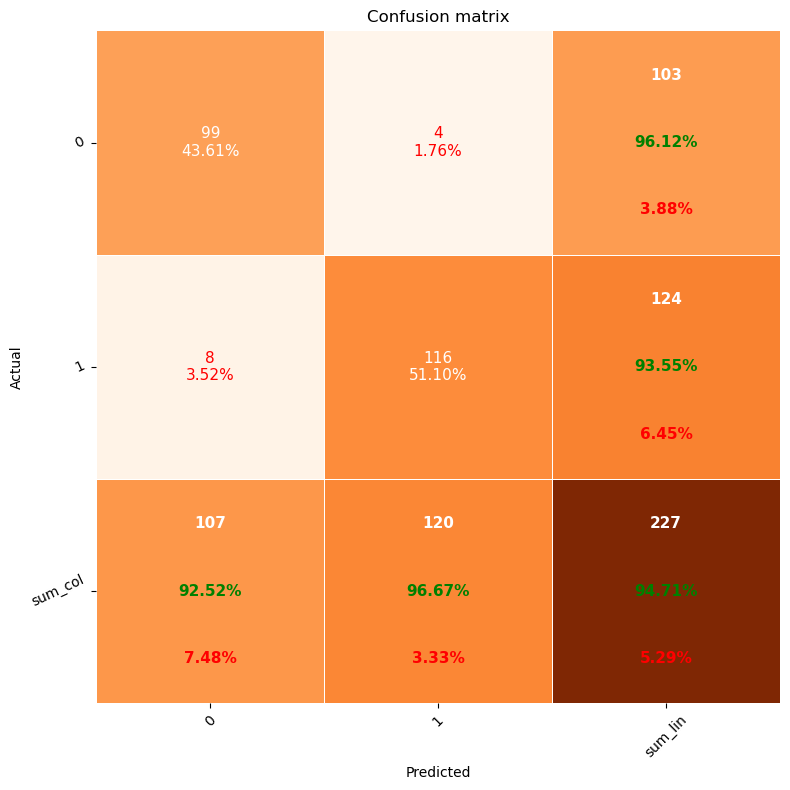

In [6]:
# Confusion matrix
import warnings
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
loss_fn = nn.BCEWithLogitsLoss()
datasets = get_tumor_tiles_datasets(CFG, train_image_dir, df_train, df_validation)
dataloaders = get_dataloaders(CFG, datasets)
y_list = []
pred_list = []
loss_list = []
metric = 0
with torch.no_grad():
    for X, y in dataloaders['validation']:
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(1).float()
        outputs = model(X)
        preds = np.where(torch.sigmoid(outputs).cpu().numpy() > 0.5, 1, 0)
        loss = loss_fn(outputs, y)
        y_list.append(y.cpu().numpy())
        pred_list.append(preds)
        loss_list.append(loss.cpu().numpy())
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=UserWarning)
            metric += balanced_accuracy_score(y.cpu().numpy(), preds)
metric /= len(dataloaders['validation'])
y_list = np.concatenate(y_list)
pred_list = np.concatenate(pred_list)
loss_list = np.array(loss_list)

from ext.pretty_confusion_matrix import pp_matrix
cm = confusion_matrix(y_list, pred_list)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])
pp_matrix(df_cm, pred_val_axis='x', cmap='Oranges', figsize=(8, 8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


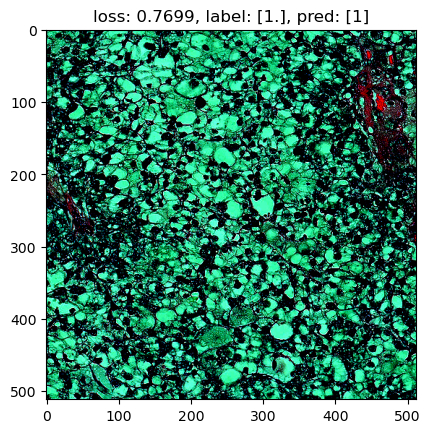

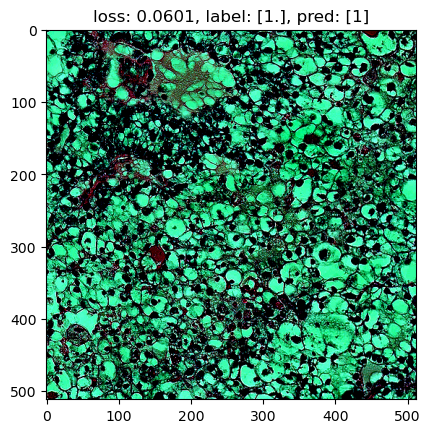

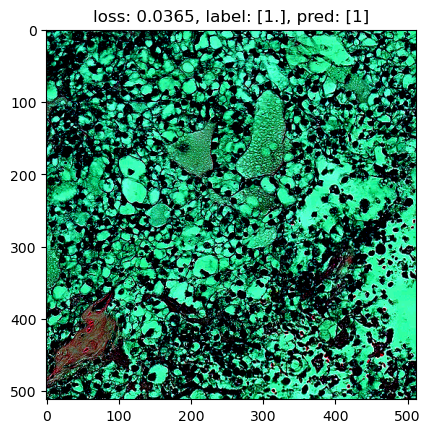

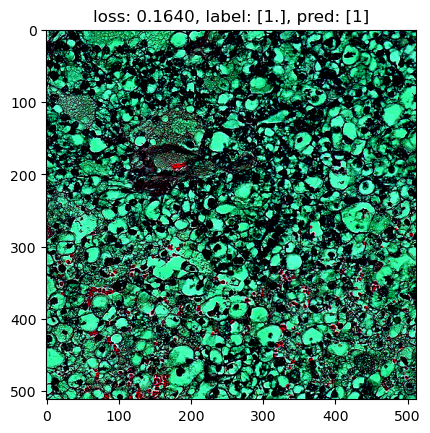

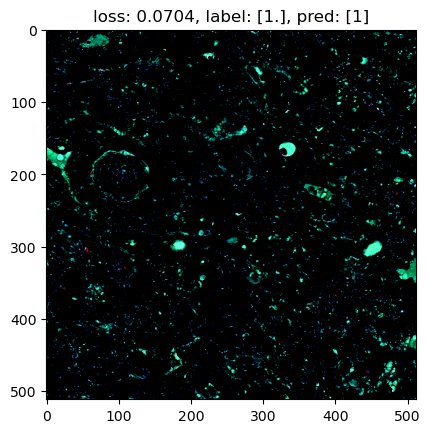

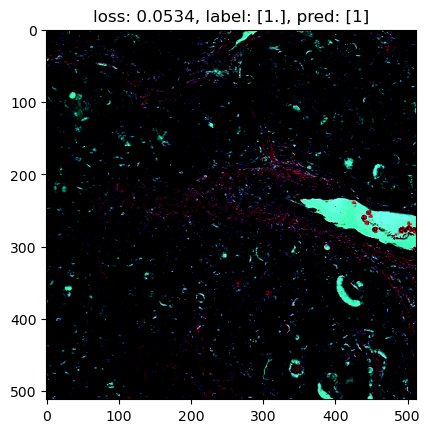

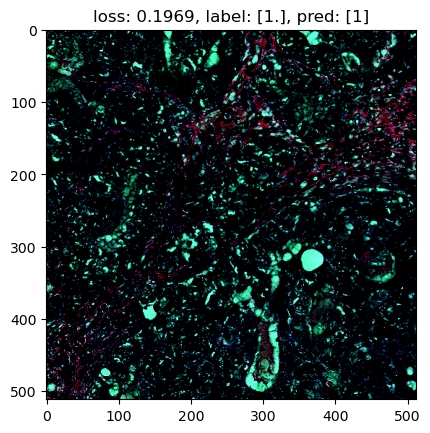

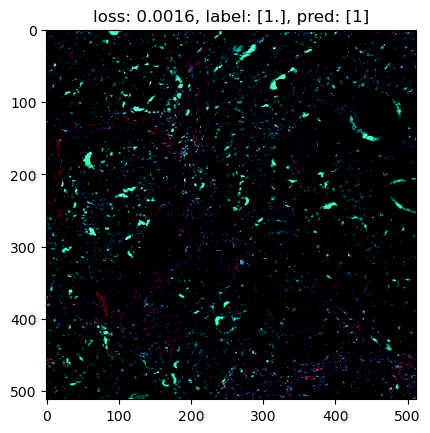

In [7]:
# Top k losses
k = 20
topk_loss_idx = list(loss_list.argsort()[-k:])
with torch.no_grad():
    for b, (X, y) in enumerate(dataloaders['validation']):
        for bi in range(len(X)):
            i = b * CFG['batch_size'] + bi
            if i not in topk_loss_idx:
                continue
            plt.figure()
            plt.imshow(X[bi].permute(1, 2, 0))
            plt.title(f'loss: {loss_list[i]:.4f}, label: {y_list[i]}, pred: {pred_list[i]}')